# Training

This treats the spectrograms of the words like images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [1]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
# clear out any old logs
!rm -rf ./logs/

In [ ]:
# List of the words in categorical order
command_words = [
    'chickenrice',
    'salad',
    'fishsoup',
    '_invalid',
]

In [2]:
# Load up the spectrograms and labels
training_spectrogram = np.load('training_spectrogram (6).npz')
validation_spectrogram = np.load('validation_spectrogram (6).npz')
test_spectrogram = np.load('test_spectrogram (6).npz')

In [5]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_test[0].shape[0]
IMG_HEIGHT=X_test[0].shape[1]
print(IMG_WIDTH)
print(IMG_HEIGHT)
print(X_test[0].shape)

99
43
(99, 43, 1)


(array([  900.,   890.,   900., 15358.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

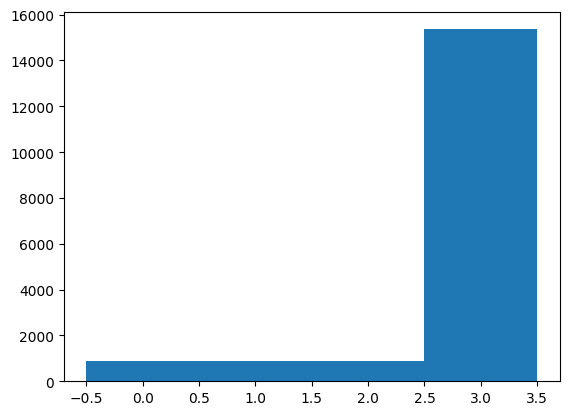

In [ ]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(command_words)+1), align='left')

In [ ]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([command_words[i] for i in unique], counts))

[0 1 2 3] [  900   890   900 15358]


{'chickenrice': 900, 'salad': 890, 'fishsoup': 900, '_invalid': 15358}

In [ ]:
Y_train = tf.one_hot(Y_train_cats, len(command_words))
Y_validate = tf.one_hot(Y_validate_cats, len(command_words))
Y_test = tf.one_hot(Y_test_cats, len(command_words))

In [ ]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0]//10)

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [ ]:
model = Sequential([
    Conv2D(4, 3,
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3,
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
    Flatten(),
    Dropout(0.1),
    Dense(
        80,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dropout(0.1),
    Dense(
        len(command_words),
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer1 (Conv2D)                 │ (None, 99, 43, 4)           │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1 (MaxPooling2D)          │ (None, 49, 21, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer2 (Conv2D)                 │ (None, 49, 21, 4)           │             148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3 (MaxPooling2D)          │ (None, 24, 10, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 80)                  │          76,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │             324 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,392 (302.31 KB)

 Trainable params: 77,392 (302.31 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=10,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9199 - loss: 0.4093 - val_accuracy: 0.9906 - val_loss: 0.1495
Epoch 2/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9922 - loss: 0.0960 - val_accuracy: 1.0000 - val_loss: 0.0516
Epoch 3/10
 18/564 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9908 - loss: 0.0927

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9953 - loss: 0.0649 - val_accuracy: 0.9906 - val_loss: 0.0988
Epoch 4/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9968 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 0.0353
Epoch 5/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9965 - loss: 0.0462 - val_accuracy: 0.9911 - val_loss: 0.0989
Epoch 6/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9980 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.0304
Epoch 7/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9974 - loss: 0.0389 - val_accuracy: 0.9911 - val_loss: 0.0918
Epoch 8/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9967 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0286
Epoch 9/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9973 - loss: 0.0387 - val_accuracy: 0.9906 - val_loss: 0.0972
Epoch 10/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9977 - loss: 0.0349 - val_accuracy: 1.0000 - val

In [ ]:
model.save("trained_model.keras")

# Testing the Model

In [ ]:
model2 =  keras.models.load_model("trained_model.keras")

In [ ]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9837 - loss: 0.0765


In [ ]:
predictions = model2.predict(X_test, 128)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

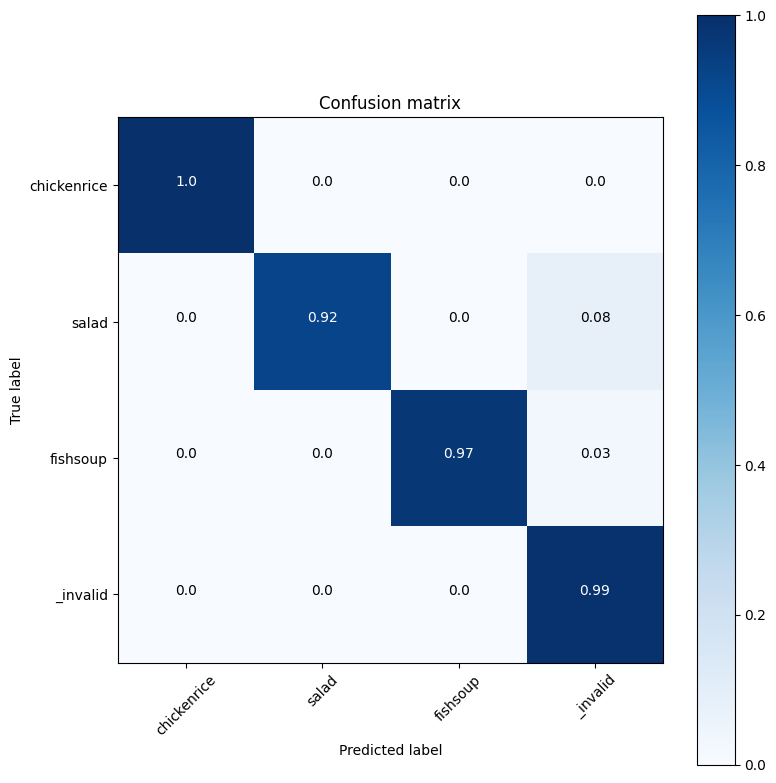

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

# Fully train the model


In [ ]:
batch_size = 30
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(len(complete_train_X)).batch(batch_size)

In [ ]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9974 - loss: 0.0398
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9972 - loss: 0.0395
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9963 - loss: 0.0382
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9968 - loss: 0.0385
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9965 - loss: 0.0375


In [ ]:
model2.save("fully_trained_model.keras")

In [ ]:
model2 = tf.keras.models.load_model("fully_trained_model.keras")

In [ ]:
results = model2.evaluate(complete_train_X, tf.cast(complete_train_Y, tf.float32), batch_size=128)

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9983 - loss: 0.0302


In [ ]:
predictions = model2.predict(complete_train_X, 128)

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


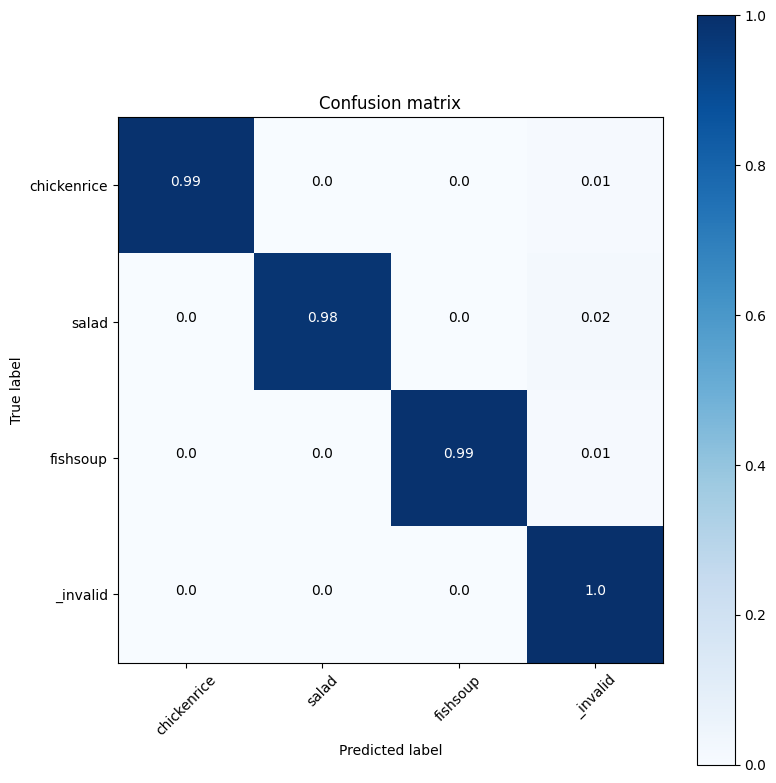

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(complete_train_Y, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)